In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from PIL import Image
np.random.seed(42)

# Config has hardcoded values and are not meant to be changed at all for this notebook
class Config:
    N = 1700
    K = 3 # theser
    D = 2 # dont change this we need 2d for interpretting plots
    iterations = 75
    eps = 1e-3
    
class Actual:
    mu = np.array([[3,3], [10, -10], [5, 20]])
    cov_norot = [
        [[4, 0], [0, 64]],
        [[16, 0], [0, 1]],
        [[16, 0], [0, 6]]
    ]
    cov = []
    rots = [45, 10, 30]
    sizes = [500, 200, 1000]

In [2]:
def rotate2D(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s],[s, c]])

def sampleMultiGaussian(mu, cov, theta, size):
    R = rotate2D(theta)
    Actual.cov.append(R.T @ cov @ R)
    return np.random.multivariate_normal(mu, Actual.cov[-1], size=size)

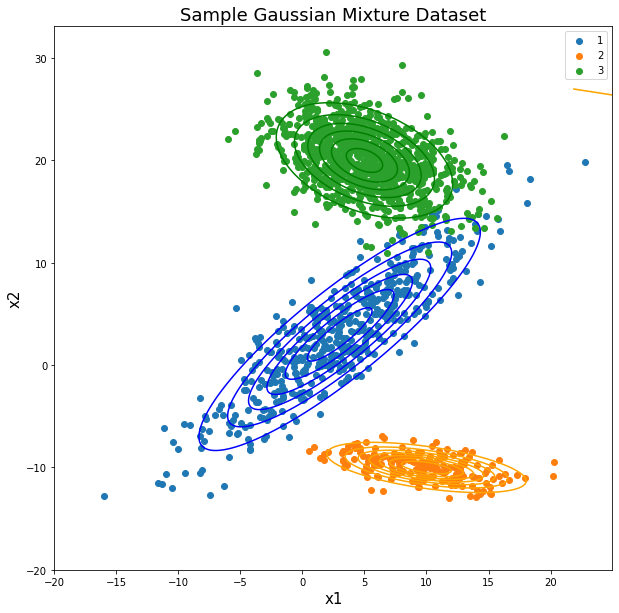

In [3]:
def sampleDistriubtion():
    fig, ax = plt.subplots(figsize=(10, 10))
    X_train = []
    y_train = []
    
    x_grid = np.arange(-20, 25, .02)
    y_grid = np.arange(-20, 27, .02)
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    colors = ['blue', 'orange', 'green']
    
    for i in range(Config.K):
        samples = sampleMultiGaussian(Actual.mu[i], Actual.cov_norot[i],
                    theta=np.radians(Actual.rots[i]), size=Actual.sizes[i])
        labels  = np.ones(Actual.sizes[i]) * i
        X_train.append(samples)
        y_train.append(labels)
        ax.scatter(samples[:,0], samples[:, 1], label=str(i+1))
        
        
        
        z_grid = scipy.stats.multivariate_normal(Actual.mu[i], Actual.cov[i]).pdf(coordinates).reshape(x_grid.shape)
        ax.contour(x_grid, y_grid, z_grid, colors=colors[i])
        
    ax.set_xlabel('x1', fontsize=15)
    ax.set_ylabel('x2', fontsize=15)

    ax.set_title('Sample Gaussian Mixture Dataset', fontsize=18)
    ax.legend()
    
    return np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)

X_train, y_train = sampleDistriubtion()

In [4]:
# helpers
def prob(X_nd, k): # (examples, k) -> [P(example1 | k), P(example2|k), ..]
    mu_1d = Params.mu[k:k+1]
    cov_dd = Params.cov[k]
    z_nd = X_nd - mu_1d
    A_nd = (z_nd @ np.linalg.inv(cov_dd))
    z_n  = (A_nd * z_nd).sum(axis=1)
    p_n  = (2*np.pi) ** (- Config.D / 2) * np.linalg.det(cov_dd) ** -.5 * np.exp(-.5 * z_n)
    return p_n

def getGamma(X_nd):
    g_kn = np.array([
        Params.pi[k, 0] * prob(X_nd, k)
        for k in range(Config.K)
    ]) # (k n)
    denom = g_kn.sum(axis=0, keepdims=True)
    denom[denom == 0.0] = 1
    g_kn /= denom # sum over clusters (k) must be one
    
    return g_kn, denom

[[ 9.50261073 -9.8934473 ]
 [ 5.08365329 20.12407537]
 [ 3.06573299  3.21816866]]
[[  3   3]
 [ 10 -10]
 [  5  20]]


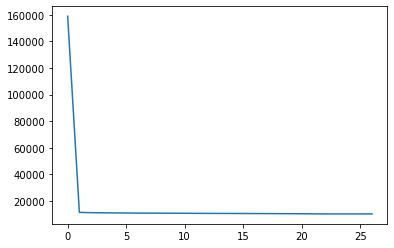

In [5]:
class Params:
    pi = np.ones((Config.K,1)) / Config.K                                # pi_k
    idx = np.random.choice(np.arange(Config.N), Config.K)
    mu = X_train[idx] * 1.0 # choose K samples randomly from dist
    del(idx)
    cov = np.array([np.eye(Config.D) for i in range(Config.K)]) # init K covs to identity

def em_one_iteration(X_nd):
    """Performs one iteration of the EM algorithm for gaussian mixture model
    Args
        * X_nd is an np.array with n examples, each of d dimensions
    Function
        * updates Params.mu, Params.cov and Params.pi
    """
    g_kn, denom = getGamma(X_nd)
    
    # N_k is gamma summed over n
    N_k1 = g_kn.sum(axis=1, keepdims=True) # shape (k,1)
    
    # new mu is examples averaged over gamma
    Params.mu = np.matmul(g_kn, X_nd) / N_k1
    Params.pi = N_k1 / Config.N
    
    # new mean is used to calculate new cov
    # calculate cov as E[x-mu] but over dist of reponse coeff
    for k in range(Config.K):
        g_n1 = g_kn[k:k+1].T
        z_nd = X_nd - Params.mu[k:k+1]
        Params.cov[k] = ((g_n1 * z_nd).T @ z_nd) / N_k1[k]

    # return log likelihood
    neg_log_likelihood = - np.log(denom).sum()
    return neg_log_likelihood

nll = []

for i in range(Config.iterations):
    loss = em_one_iteration(X_train)
    nll.append(loss)
    if len(nll) > 1 and np.abs(loss - nll[-2]) < Config.eps:
        break
plt.plot(nll)
print(Params.mu)
print(Actual.mu)

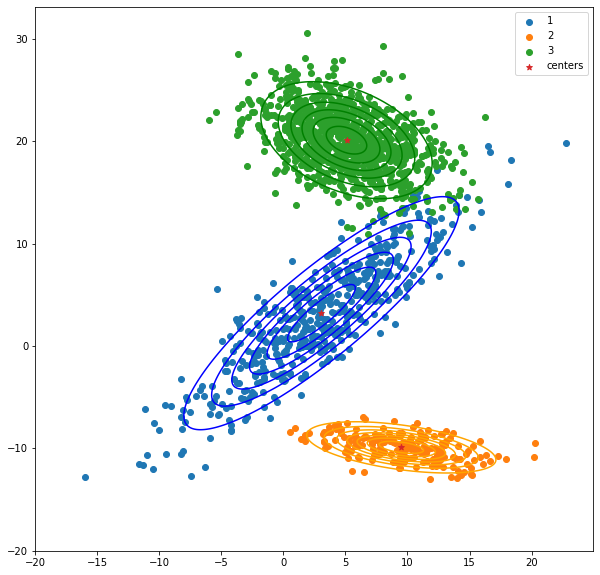

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
parts = np.cumsum([0] + Actual.sizes)

x_grid = np.arange(-20, 25, .02)
y_grid = np.arange(-20, 27, .02)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
colors = ['orange', 'green', 'blue']
       
for k in range(Config.K):
    x = X_train[parts[k]:parts[k+1]]
    ax.scatter(x[:,0], x[:,1], label=str(k+1))
    z_grid = scipy.stats.multivariate_normal(Params.mu[k], Params.cov[k]).pdf(coordinates).reshape(x_grid.shape)
    ax.contour(x_grid, y_grid, z_grid, colors=colors[k])
    
ax.scatter(Params.mu[:,0], Params.mu[:,1], marker='*', label='centers')
plt.legend();

In [ ]:
class Params:
    pi = np.ones((Config.K,1)) / Config.K                                # pi_k
    idx = np.random.choice(np.arange(Config.N), Config.K)
    mu = X_train[idx] * 1.0 # choose K samples randomly from dist
    del(idx)
    cov = np.array([np.eye(Config.D) for i in range(Config.K)]) # init K covs to identity

def gd_one_iteration(X_nd):
    """Performs one iteration of the EM algorithm for gaussian mixture model
    Args
        * X_nd is an np.array with n examples, each of d dimensions
    Function
        * updates Params.mu, Params.cov and Params.pi
    """
    g_kn, denom = getGamma(X_nd)
    
    # N_k is gamma summed over n
    N_k1 = g_kn.sum(axis=1, keepdims=True) # shape (k,1)
    
    # new mu is examples averaged over gamma
    Params.mu = np.matmul(g_kn, X_nd) / N_k1
    Params.pi = N_k1 / Config.N
    
    # new mean is used to calculate new cov
    # calculate cov as E[x-mu] but over dist of reponse coeff
    for k in range(Config.K):
        g_n1 = g_kn[k:k+1].T
        z_nd = X_nd - Params.mu[k:k+1]
        Params.cov[k] = ((g_n1 * z_nd).T @ z_nd) / N_k1[k]

    # return log likelihood
    neg_log_likelihood = - np.log(denom).sum()
    return neg_log_likelihood

nll = []

for i in range(Config.iterations):
    loss = em_one_iteration(X_train)
    nll.append(loss)
    if len(nll) > 1 and np.abs(loss - nll[-2]) < Config.eps:
        break
plt.plot(nll)
print(Params.mu)
print(Actual.mu)